In [1]:
import numpy as np
from ito_diffusions.ito_diffusion_1d import FBM
from hurst_fitter import Hurst_fitter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
T = 1.0
SCHEME_STEPS = int(252 * 4)
fitter = Hurst_fitter(n_lags=10)

# Goal

Assume $(Bid_t)$ and $(Ask_t) = (Bid_t + S)$ are two fractional Brownian motion (fBM) separated by a spread $S$ (assumed to be constant for now). We are interested in finding a Brownian motion, or at least an Ito process driven by a Brownian motion, $(Mid_t)$ such that $Bid_t \leq Mid_t \leq Ask_t$.

The financial rationale behind is to model a situation where the mid price is indeed martingale (up to discounting/change of measure) but the observed market prices (bid and ask) exhibit statistical patterns (momentum or mean-reversion depending on whether the Hurst index for the fBM is higher or lower than $\frac{1}{2}$). These statistical deviations from arbitrage-free martingales can sometimes be observed in less liquid or less electronified markets, where information lags and slow execution prevent the potential arbitragers to "arb them out" quickly. Predicting a statistically implied mid price may provide interesting information ("true" mid vs $\frac{bid+ask}{2}$, order book trend...).

To do so, we look for $Mid$ as a convex combination of $Bid$ and $Ask$ with random weights:

$$
Mid_t = \alpha_t Bid_t + (1-\alpha_t) Ask_t
$$

where $\alpha$ is a Gaussian process with covariance function $\gamma_{\alpha}(s, t) = Cov(\alpha_s, \alpha_t) $ such that $Mid_t$ has the covariance structure of the Brownian motion. Note that the drift of $alpha$ is a degree of freedom.

We investigate two models:

1) **Constant mean**: for instance $\alpha \sim \mathcal{N}(\frac{1}{2}, \gamma_{\alpha})$. This model does not enforce the contraint $0\leq \alpha_t \leq 1$ for all $t$, which may be an issue (although for "reasonable" values of the parameters, the variance around $\frac{1}{2}$ is small enough so that the probability to escape the interval $[0, 1]$ is fairly small, and moreover the process can clipped to artificially enforce this).

2) **Contained Gaussian process**: $d\alpha_t = \kappa (\frac{1}{\alpha_t^\beta} - \frac{1}{(1-\alpha_t)^\beta})dt + \sigma dX_t$ with $\beta>1$ to enforce the constraint $0\leq \alpha_t \leq 1$ a.s for all $t$, and $X$ is a centered Gaussian process with covariance $\gamma_{\alpha}$. Note that we proved the non-explosion test for $\alpha$ (that guarantees that $\alpha$ stays within bounds) only when $X$ is a Brownian motion, so the theoretical ground for the more general case at hand is conjectural, albeit intuitive.

In [3]:
spread = 2.0
H = 0.7
vol_bid = 1.0

Bid = FBM(x0=100, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=vol_bid, H=H)

In [4]:
vol_mid = 1.5
gamma_h = lambda s, t: 0.5 * vol_bid ** 2 * (t ** (2 * H) + s ** (2 * H) - np.abs(t - s) ** (2 * H))
gamma_alpha = lambda s, t: (vol_mid ** 2 * np.min([s, t]) - gamma_h(s, t)) / spread ** 2

cov_alpha = np.zeros((Bid.scheme_steps + 1, Bid.scheme_steps + 1))
for i in range(Bid.scheme_steps + 1):
    cov_alpha[i][i] = gamma_alpha(i * Bid.scheme_step, i * Bid.scheme_step)
    for j in range(i):
        cov_alpha[i][j] = gamma_alpha(i * Bid.scheme_step, j * Bid.scheme_step)
        cov_alpha[j][i] = cov_alpha[i][j]
        
cum_noise = np.random.multivariate_normal(
    np.zeros((Bid.scheme_steps + 1,)),
    cov_alpha
    )

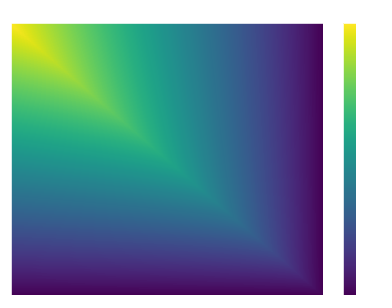

In [5]:
fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
im = ax.pcolormesh(cov_alpha[:, ::-1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Covariance matrix')
fig.colorbar(im, ax=ax)
plt.show()

## Constant mean

In [6]:
alpha_cm = np.clip(0.5 + cum_noise, 0.0, 1.0)

## Contained Gaussian process

In [7]:
noises = cum_noise[1:] - cum_noise[:-1]

alpha_cgp = np.empty(Bid.scheme_steps + 1)

last_step = 0.5
alpha_cgp[0] = last_step
sigma = 2.0
kappa = 1.0
beta = 2.0

drift = lambda x: kappa * (x ** (-beta) - (1 - x) ** (-beta))

for i, z in enumerate(noises):
    last_step += drift(last_step) * Bid.scheme_step + sigma * z
    alpha_cgp[i + 1] = last_step

## Plot

/home/sauxpa/anaconda3/lib/python3.7/site-packages/hurst_fitter/main.py:50: RuntimeWarning: divide by zero encountered in power
  - 2 * np.abs(lag) ** (2 * H)
/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


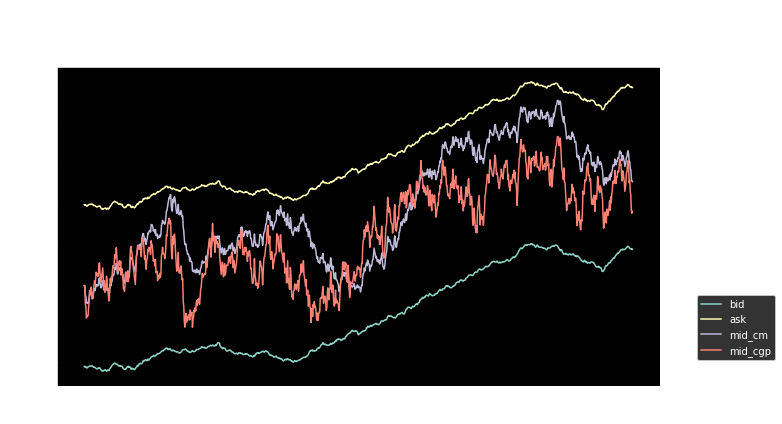

In [8]:
fig, ax = plt.subplots(figsize=(11, 6), nrows=1, ncols=1)
df = Bid.simulate()
df.rename(columns={'spot': 'bid'}, inplace=True)
df['ask'] = df['bid'] + spread
df['mid_cm'] = df['bid'] + alpha_cm * spread
df['mid_cgp'] = df['bid'] + alpha_cgp * spread

fitter.df = df['bid']
H_bid = fitter.fit()
fitter.df = df['ask']
H_ask = fitter.fit()
fitter.df = df['mid_cm']
H_mid_cm = fitter.fit()
fitter.df = df['mid_cgp']
H_mid_cgp = fitter.fit()

df.plot(kind='line', ax=ax)

ax.set_xlabel('time')
ax.set_ylabel('spot')
ax.legend(bbox_to_anchor=(1.2, 0.3))
ax.set_title(
    'H_bid = {:.2f}\nH_ask = {:.2f}\nH_mid_cm = {:.2f}\nH_mid_cgp = {:.2f}'.format(
        H_bid, H_ask, H_mid_cm, H_mid_cgp,
    )
)

plt.tight_layout()
plt.show()

fig.savefig('brownian_implied_mid.png', dpi=600)